In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#visualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
data = pd.read_csv("MVC.csv")
print(data.columns)

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'NUMTIME'],
      dtype='object')


In [4]:
data = data[['BOROUGH','NUMTIME','LONGITUDE','LATITUDE','CONTRIBUTING FACTOR VEHICLE 1','NUMBER OF PERSONS KILLED','NUMBER OF PERSONS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF PEDESTRIANS INJURED']]
data['PERSONS_AFFECTED'] = data['NUMBER OF PERSONS KILLED'] + data['NUMBER OF PERSONS INJURED']
data['PEDESTRIANS_AFFECTED'] = data['NUMBER OF PEDESTRIANS KILLED'] + data['NUMBER OF PEDESTRIANS INJURED']

In [5]:
borough_dummy = data.BOROUGH.str.get_dummies()
data = pd.concat([data,borough_dummy],axis=1)

data = data.dropna()
data = data[data.LONGITUDE !=0]

data['PERSONS_TF']=0
data.loc[data['PERSONS_AFFECTED'] > 0, 'PERSONS_TF']= 1
data.loc[data['PERSONS_AFFECTED'] == 0, 'PERSONS_TF']= 0

In [6]:
value_counts = data["CONTRIBUTING FACTOR VEHICLE 1"].value_counts(ascending=True)
remove = value_counts[value_counts <= 20].index
data = data[~data['CONTRIBUTING FACTOR VEHICLE 1'].isin(remove)]

data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Driver Inattention/Distraction','Following Too Closely','Failure to Yield Right-of-Way','Backing Unsafely','Passing Too Closely','Unsafe Lane Changing','Passing or Lane Usage Improper','Turning Improperly','Traffic Control Disregarded','Driver Inexperience','Reaction to Uninvolved Vehicle','Unsafe Speed','Fatigued/Drowsy','Alcohol Involvement','Lost Consciousness','Aggressive Driving/Road Rage','Fell Asleep','Illnes','Drugs (illegal)','Drugs (Illegal)','Texting','Outside Car Distraction','Passenger Distraction','Prescription Medication','Failure to Keep Right','Illness','Other Electronic Device','Cell Phone (hand-Held)','Cell Phone (hands-free)','Eating or Drinking','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion','Physical Disability','Reaction to Other Uninvolved Vehicle','Using On Board Navigation Device','Tinted Windows','Vehicle Vandalism','Cell Phone (hand-held)'],'Human')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Other Vehicular','Oversized Vehicle','Brakes Defective','Steering Failure','Tire Failure/Inadequate','Driverless/Runaway Vehicle','Accelerator Defective','Other Lighting Defects','Tow Hitch Defective','Headlights Defective','Windshield Inadequate'],'Vehicular')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Pavement Slippery','View Obstructed/Limited','Glare','Obstruction/Debris','Pavement Defective','Animals Action','Lane Marking Improper/Inadequate','Traffic Control Device Improper/Non-Working','Shoulders Defective/Improper'],'Environmental')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['80'],'Unspecified')

In [7]:
factor_dummy = data['CONTRIBUTING FACTOR VEHICLE 1'].str.get_dummies()
data = pd.concat([data,factor_dummy],axis=1)

In [8]:
pred = list(zip(data['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
resp = data['PERSONS_TF']

In [9]:
X_feat = pred
y = resp
X_feat_train,X_feat_test, y_feat_train,y_feat_test = train_test_split(X_feat,y,test_size=0.2)

dtc = RandomForestClassifier()
grid={'max_depth':[1,2,3,4,5,10,20,30],
        'criterion':['gini','entropy'],
        'min_samples_leaf':[10,20,30,50,60]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False,n_jobs=-1)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.7min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)
y_test_pred = t.predict(X_test)


print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))
print("Null accuracy on the test set: ",y_test.mean())
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='micro'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='micro'))
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90    106167
           1       0.00      0.00      0.00     24727

    accuracy                           0.81    130894
   macro avg       0.41      0.50      0.45    130894
weighted avg       0.66      0.81      0.73    130894

Null accuracy on the test set:  0.18890858251715129
Sensitivity/Recall (TPR):  0.8110914174828487
Precision (PPV):  0.8110914174828487


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[106167,      0],
       [ 24727,      0]])

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

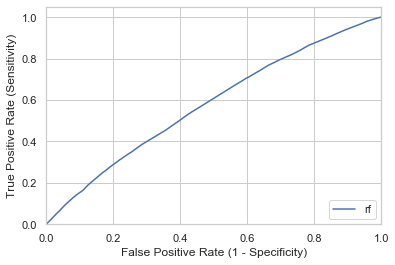

In [11]:
X_feat = pred

y = resp

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t2 = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_leaf=20)

t2.fit(X_train,y_train)
y_test_pred = t2.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)

sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [12]:

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
print("RF model AUC: ",metrics.roc_auc_score(y_test, y_test_pred))



RF model AUC:  0.5782160262643072


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

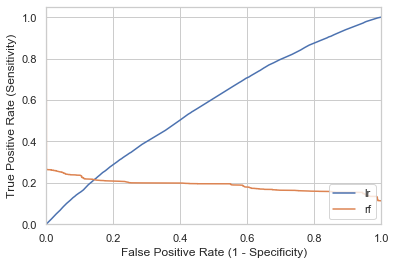

In [13]:

y_test_pred = t2.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="lr")
sns.mpl.pyplot.plot(fpr_rf, thresholds_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [14]:
X_feat = pred

y = resp

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
accs = []
for i in depths:
    dtc = DecisionTreeClassifier(max_depth=i,criterion='entropy',min_samples_leaf=20)
    dtc.fit(X_train,y_train)
    accs.append(dtc.score(X_test,y_test))
    
print('Scores:\n',pd.DataFrame({'Accuracy':accs},index=depths))

Scores:
     Accuracy
1   0.810251
2   0.810251
3   0.810251
4   0.810251
5   0.810251
10  0.810091
15  0.809938
20  0.809961
25  0.809923
30  0.809923
